# Variational Inference with Automatic Guides in Numpyro, and NUTS, on a model of NeuroImaging 

In this notebook, we perform Bayesian Inference in Numpyro on a neural mass model of neuroimaging. We report and compare results of Stochastic Variational Inference (SVI) and MCMC NUTS. Numpyro's autoguides automatically derive a variational family for SVI from a Numpyro model. We test three of these guides: mean-field Gaussian, full-rank Gaussian and Laplace Gaussian quadratic approximation. 

In [1]:
import os
import sys
import time
import errno
import timeit
import pathlib
import pickle 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import arviz as az
sns.set_context("paper", font_scale=2, rc={"axes.labelsize":18})
from collections import ChainMap
import pandas as pd

In [2]:
import jax 
import jax.numpy as jnp
from jax import grad, vmap, lax, random
from jax.experimental.ode import odeint

In [3]:
import torch
import torch.distributions.constraints as constraints
import numpyro as npr 
import numpyro.distributions as dist
from numpyro.distributions import constraints
from numpyro.infer import Predictive, SVI, MCMC, NUTS, Trace_ELBO, TraceMeanField_ELBO, init_to_mean, init_to_value
from numpyro.infer.autoguide import *
from numpyro.optim import Adam

In [4]:
npr.set_platform("cpu")

In [5]:
#See the dependency at last cell!
print(f"Numpy version: {np.__version__}")
print(f"JAX version: {jax.__version__}")
print(f"Numpyro version: {npr.__version__}")
print(f"Arviz version: {az.__version__}")

Numpy version: 1.26.4
JAX version: 0.4.13
Numpyro version: 0.12.1
Arviz version: 0.17.0


In [6]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action="ignore", category=FutureWarning)

In [7]:
cwd = os.getcwd()
main_path = str(pathlib.Path.cwd().parent)
sys.path.append(main_path) # Path to import the model and solver

output_dir= cwd + '/output_numpyro/'
! mkdir -p $output_dir

In [8]:
from ForwardModel.ERPmodel_JAX import DCM_ERPmodel, odeint_euler, odeint_heun, odeint_rk4

In [9]:
def dict_from_list_of_dicts(list_of_dicts) :
    newdict={}
    for k,v in [(key,d[key]) for d in list_of_dicts for key in d]:
        if k not in newdict: newdict[k]=[v]
        else: newdict[k].append(v)
    return newdict

def mse(x, y) :
    return np.mean((x - y)**2)

def get_z_score(posterior, true_prm) :
    return np.abs(np.mean(posterior) - true_prm) / np.std(posterior)

def compute_marks(az_trace) :
    r_hat = az.rhat(az_trace, var_names=my_var_names).to_array().values
    mse_fit = mse(xpy_obs, az_trace.posterior['xpy_model'].mean(axis=(0, 1)).to_numpy().flatten())
    corr = az.extract(az_trace, var_names=my_var_names).to_pandas().corr().to_numpy()
    corr[np.tril_indices(corr.shape[0])] = np.nan
    z_scores = [get_z_score(az_trace.posterior[my_var_names[i]], theta_true[i]) for i in range(n_params)]
    
    return {'r hat': r_hat,
            'mean r hat': np.mean(r_hat),
            'MSE fit': mse_fit,
            'mean corr': np.nanmean(np.abs(corr)),
            'min corr': np.nanmin(np.abs(corr)),
            'max corr': np.nanmax(np.abs(corr)),
            'min zscore': np.min(z_scores),
            'max zscore': np.max(z_scores)}
    
def append_marks(df, setup, time, marks_dict) :
    return df._append({'setup': setup,
                       'time': time,
                       **{k:v for k, v in marks_dict.items()}
                      }, ignore_index=True)
bench_df = pd.DataFrame({})

## Background

### Motivation

Ordinary differential equation models (ODEs) are used in a variety of science and engineering domains to model the time evolution of physical variables.  A natural choice to estimate the values and uncertainty of model parameters given experimental data is Bayesian inference.  However, ODEs can be challenging to specify and solve in the Bayesian setting, therefore, this notebook steps through multiple methods for solving an ODE inference problem using JAX's Odeint. Alternative is to use diffrax, which can be found in forward simulations in the repo. The neural mass model used in this example has often been used in dynamical causal modeling and other approaches to fit various neuroimaging data such as ERP/EEG/MEG.

### Neural Mass Model

The mode of Olivier David et al describes the interaction between theree neural populations of pyramidal (x9), 
inhibitory interneuron (x7) 
spiny-stellate cells (x1).

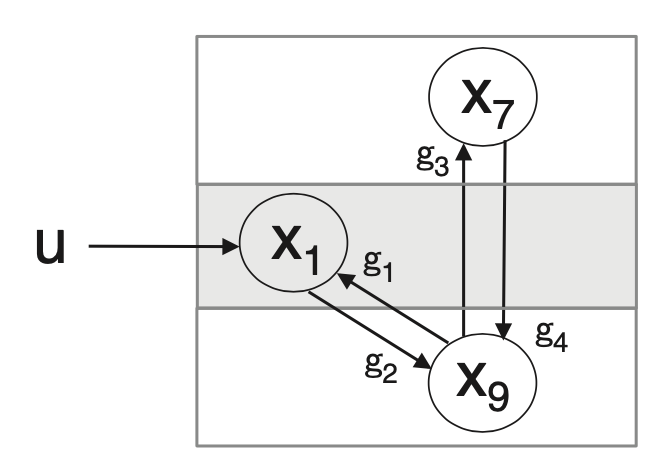

In [10]:
from IPython.display import Image
Image(filename='../Images/model.png', width=400)

This ODE given by:




\begin{equation}
    \begin{aligned}
    \dot x_1(t) &= x_4 (t) \\
    \dot x_2(t) &= x_5(t) \\
    \dot x_3(t) &= \dfrac{h_e}{\tau_e} \left( g_1 \left( 
    \dfrac{1}{\exp^{-0.56 x_9 (t - \delta)} + 1} - 0.5 \right) + u \right) - \dfrac{x_1(t)}{\tau_e^2} - \dfrac{2 x_4(t)}{\tau_e} \\
    \dot x_5(t) &= \dfrac{g_2 h_e}{\tau_e}  \left( 
    \dfrac{1}{\exp^{-0.56 x_1 (t - \delta)} + 1} -0.5 \right) - \dfrac{x_2(t)}{\tau_e^2} - \dfrac{2 x_5(t)}{\tau_e} \\
    \dot x_6(t) &= \dfrac{g_4 h_i}{\tau_i}  \left( 
    \dfrac{1}{\exp^{-0.56 x_7 (t - \delta)} + 1} -0.5 \right) - \dfrac{x_3(t)}{\tau_i^2} - \dfrac{2 x_6(t)}{\tau_i} \\
    \dot x_7(t) &= x_8(t) \\
    \dot x_8(t) &= \dfrac{g_3 h_e}{\tau_e}  \left( 
    \dfrac{1}{\exp^{-0.56 x_9 (t - \delta)} + 1} -0.5 \right) - \dfrac{x_7(t)}{\tau_e^2} - \dfrac{2 x_8(t)}{\tau_e} \\
    \dot x_9(t) &= x_5(t) - x_6(t)
\end{aligned}
\end{equation}




The state vector $X(t)=[x_1(t), ...x_9(t)]$ comprises the densities of activity of neural populations. Parameters $\boldsymbol{\theta}=[g_1, g_2, g_3, g_4, \delta,\tau_i, h_i, \tau_e, h_e, u ]$ are the unknowns that we wish to infer from experimental observations.

$x(0)$ represents the initial values of the states needed to solve the ODE and is fixed to zero for all variables.

The unknown model parameters represent the following:

* $g_1, g_2, g_3, g_4$ are connection strengths.
* $\delta$ is the intrinsic delay.
* $h_{e,i}$ represents the maximum amplitude of excitatory (e) and inhibitory (i) post-synaptic potentials.
* $\tau_{e, i}$ are the rate constants for excitatory and inhibitory synaptic inputs, respectively.
* $u$  represents the input to each neural population

## Simulator

In [11]:
rng_key = jax.random.PRNGKey(0)

In [12]:
tend = 200.0
dt = 0.1
t0 = 0.0
ts = np.arange(t0, tend + dt, dt)
nt = ts.shape[0]

In [13]:
ns = 9
x_init=np.zeros((ns))

In [14]:
theta_true = np.array([0.42, 0.76, 0.15, 0.16, 12.13, 7.77, 27.87, 5.77, 1.63, 3.94])
n_params = theta_true.shape[0]

In [15]:
my_var_names = ['g_1', 'g_2', 'g_3', 'g_4', 'delta', 'tau_i', 'h_i', 'tau_e', 'h_e', 'u']
params_true = dict(zip(my_var_names, theta_true))

Run the model

In [16]:
%%time
xs_euler = odeint_euler(DCM_ERPmodel, x_init, ts, theta_true)

CPU times: user 99.3 ms, sys: 12.7 ms, total: 112 ms
Wall time: 104 ms


We use Euler integration (see the ForwardModel for Heun and Rk4 integratores), But don't worry about computional time! we put JAX's JIT on Odeint to make it more faster!

In [17]:
@jax.jit
def ERP_JAXOdeintSimulator(x_init, ts, params):

    xs_rk4 = odeint_euler(DCM_ERPmodel, x_init, ts, params)    
    x_py=xs_rk4[:,8]
    
    return x_py

The initial compilation takes a bit of time, but after that, it flies through the air!

In [18]:
start_time = time.time()

xpy_jax=ERP_JAXOdeintSimulator(x_init, ts, theta_true)

print("simulation with compiling took (sec):" , (time.time() - start_time))

simulation with compiling took (sec): 0.08867454528808594


In [19]:
start_time = time.time()

xpy_jax=ERP_JAXOdeintSimulator(x_init, ts, theta_true)

print("simulation using JAX's JIT took (sec):" , (time.time() - start_time))

simulation using JAX's JIT took (sec): 0.0007660388946533203


## Synthetic Observation

We assume that we only have access to the activity of pyramidal neurons, and for the sake of speeding the computational time, we downsample the simuations.

In [20]:
#observation noise
sigma_true = 0.1 

In [21]:
xpy_jax = ERP_JAXOdeintSimulator(x_init, ts, theta_true)
x_noise = np.random.normal(loc=0, scale=sigma_true, size=xpy_jax.shape)
x_py = xpy_jax + x_noise

In [22]:
#downsampling
ds=10

In [23]:
ts_obs=ts[::ds]
xpy_obs=x_py[::ds]
nt_obs=int(x_py[::ds].shape[0])

In [24]:
ts_obs.shape, xpy_obs.shape, nt_obs

((201,), (201,), 201)

In [25]:
data= { 'nt_obs': nt_obs, 'ds': ds, 'ts': ts, 'ts_obs': ts_obs, 'dt': dt, 'x_init': x_init, 'obs_err': sigma_true, 'xpy_obs': xpy_obs }

In [26]:
from Helper.ERPhelper import *

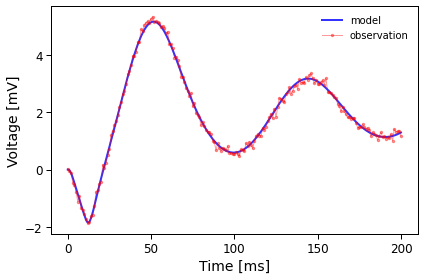

In [27]:
plot_observation(ts, xpy_jax, ts_obs, xpy_obs);

## Prior

Since all the parameters are positive, we place Gamma prior, according to Refs [3,4].

In [28]:
shape=[18.16, 29.9, 29.14, 30.77, 22.87, 34.67, 20.44, 33.02, 24.17, 23.62]
scale=[0.03, 0.02, 0.005, 0.007, 0.51, 0.23, 0.96, 0.16, 0.07, 0.13]
rate = 1. / np.array(scale)
std_prior = np.sqrt(np.array(shape)) * np.array(scale) 

In [29]:
prior_specs = dict(shape=shape, rate=rate)

In [30]:
def model(data, prior_specs):

    #Data
    dt = data['dt']
    ts = data['ts']
    ds = data['ds']
    nt_obs = data['nt_obs']
    x_init = data['x_init']
    obs_err= data['obs_err']
    obs = data['xpy_obs']

    # Prior               
    g_1 = npr.sample('g_1', dist.Gamma(prior_specs['shape'][0], prior_specs['rate'][0]))
    g_2 = npr.sample('g_2', dist.Gamma(prior_specs['shape'][1], prior_specs['rate'][1]))
    g_3 = npr.sample('g_3', dist.Gamma(prior_specs['shape'][2], prior_specs['rate'][2]))
    g_4 = npr.sample('g_4', dist.Gamma(prior_specs['shape'][3], prior_specs['rate'][3]))
    delta = npr.sample('delta', dist.Gamma(prior_specs['shape'][4], prior_specs['rate'][4]))
    tau_i = npr.sample('tau_i', dist.Gamma(prior_specs['shape'][5], prior_specs['rate'][5]))
    h_i = npr.sample('h_i', dist.Gamma(prior_specs['shape'][6], prior_specs['rate'][6]))
    tau_e = npr.sample('tau_e', dist.Gamma(prior_specs['shape'][7], prior_specs['rate'][7]))
    h_e = npr.sample('h_e', dist.Gamma(prior_specs['shape'][8], prior_specs['rate'][8]))
    u = npr.sample('u', dist.Gamma(prior_specs['shape'][9], prior_specs['rate'][9]))


    #Parameters    
    params_samples=[g_1, g_2, g_3, g_4, delta, tau_i,  h_i, tau_e, h_e, u]

    #Forward model
    xpy_hat=ERP_JAXOdeintSimulator(x_init, ts, params_samples)[::ds]

    # Likelihood
    with npr.plate('data', size=nt_obs):
        xpy_model = npr.deterministic('xpy_model', xpy_hat)
        npr.sample('xpy_obs', dist.Normal(xpy_model, obs_err), obs=obs)
        xpy_ppc = npr.sample('xpy_ppc', dist.Normal(xpy_model, obs_err))


### Prior predictive check

In [31]:
n_ = 100
prior_predictive = Predictive(model, num_samples=n_)
prior_predictions = prior_predictive(rng_key, data, prior_specs)

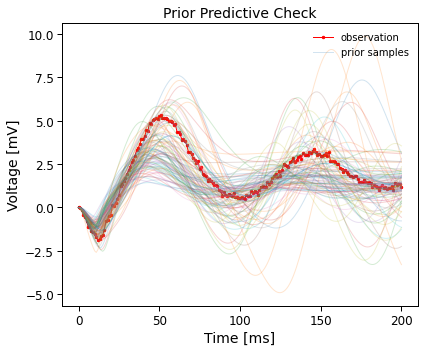

In [32]:
title='Prior Predictive Check'
plot_priorcheck(ts_obs, xpy_obs, prior_predictions, n_, title);

In [33]:
lr = 0.0005 #learning rate for the optimizer
n_iters = 100000
n_chains = 4

In [34]:
rng_key = jax.random.PRNGKey(0)
init_params=tails_percentile(my_var_names, prior_predictions, 0.05)    
init_fn = init_to_value(values=init_params)

## VI Full-rank

In [35]:
optimizer = Adam(lr)
guide_fr = AutoMultivariateNormal(model, init_loc_fn=init_fn, )
svi_fr = SVI(model, guide_fr, optimizer, loss=Trace_ELBO())

In [36]:
loss_fr = []
params_fr = []
posterior_fr_list = []
time_fr = []

rng_key = jax.random.PRNGKey(0)

for _ in range(n_chains) :
    
    start = time.time()
    rng_key, rng_subkey = random.split(key=rng_key)
    
    init_state = svi_fr.init(rng_key, data, prior_specs)
    svi_fr_result = svi_fr.run(rng_key, n_iters, data, prior_specs, stable_update=True,
                               init_state=init_state)
    
    time_fr.append(time.time() - start)
    loss_fr.append(svi_fr_result.losses)
    params_svi = svi_fr_result.params
    params_fr.append(params_svi)
    posterior_fr_list.append(guide_fr.sample_posterior(rng_key, params_svi, sample_shape=(200,)))
    
    print('SVI full-rank took ', time_fr[-1], ' seconds')

100%|█| 100000/100000 [03:03<00:00, 544.42it/s, init loss: 54720.5000, avg. loss


SVI full-rank took  198.56725883483887  seconds


100%|█| 100000/100000 [03:15<00:00, 511.84it/s, init loss: 51891.3125, avg. loss


SVI full-rank took  204.1219789981842  seconds


100%|█| 100000/100000 [02:59<00:00, 557.68it/s, init loss: 52595.5898, avg. loss


SVI full-rank took  188.08952379226685  seconds


100%|█| 100000/100000 [02:59<00:00, 557.08it/s, init loss: 52863.2305, avg. loss


SVI full-rank took  188.3483531475067  seconds


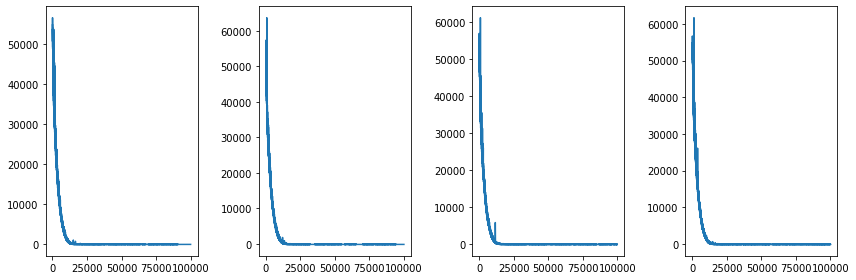

In [37]:
fig, ax = plt.subplots(ncols=n_chains, figsize=(12, 4)) 
for i in range(n_chains) :
    ax[i].plot(loss_fr[i])
fig.tight_layout()

In [38]:
posterior_fr = dict_from_list_of_dicts(posterior_fr_list)

az.summary(az.from_dict(posterior_fr), var_names=my_var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
g_1,0.533,0.122,0.313,0.737,0.004,0.003,799.0,733.0,1.01
g_2,0.648,0.013,0.624,0.672,0.000,0.000,879.0,706.0,1.00
g_3,0.146,0.008,0.131,0.162,0.000,0.000,848.0,860.0,1.00
g_4,0.215,0.012,0.190,0.234,0.000,0.000,821.0,855.0,1.01
delta,12.347,0.198,11.953,12.687,0.007,0.005,763.0,761.0,1.00
tau_i,7.709,0.077,7.570,7.856,0.003,0.002,631.0,656.0,1.01
h_i,18.274,0.490,17.251,19.102,0.018,0.013,764.0,711.0,1.00
tau_e,5.704,0.083,5.548,5.854,0.003,0.002,796.0,810.0,1.00
h_e,1.916,0.036,1.848,1.982,0.001,0.001,910.0,720.0,1.00
u,3.286,0.572,2.135,4.243,0.021,0.015,761.0,685.0,1.00


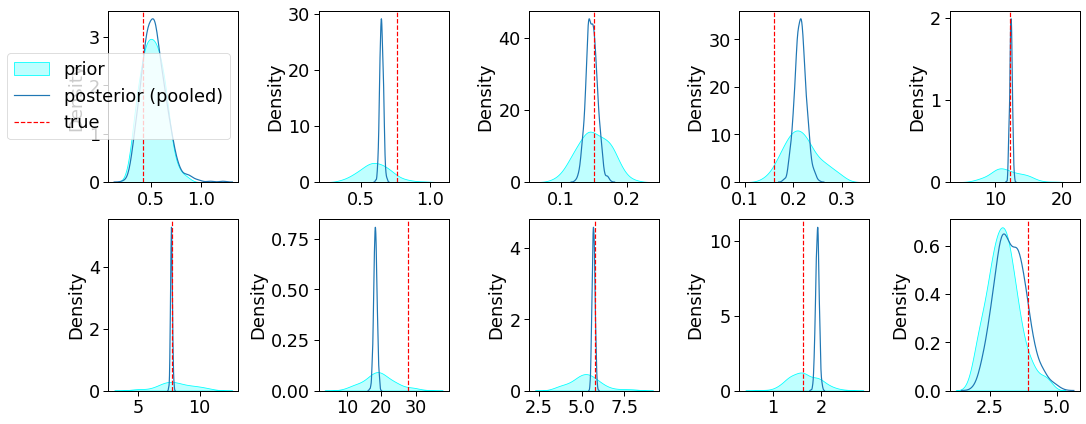

In [39]:
fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(15, 6))
for i in range(10) :
    sns.kdeplot(prior_predictions[my_var_names[i]], ax=ax[i//5, i%5], color='cyan', zorder=0, fill=True,
               label='prior')
    sns.kdeplot(np.array(posterior_fr[my_var_names[i]]).flatten(), 
                ax=ax[i//5, i%5], label='posterior (pooled)')
    ax[i//5, i%5].axvline(theta_true[i], color='red', linestyle='--', label='true')
ax[0, 0].legend() 
fig.tight_layout() 
plt.show()

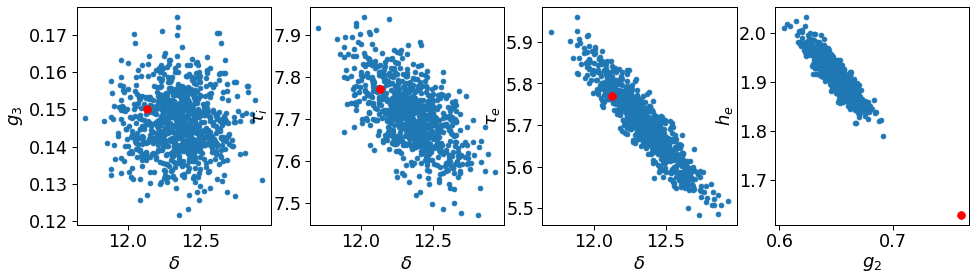

In [40]:
prms_sel = [('delta', 'g_3'), ('delta', 'tau_i'), ('delta', 'tau_e'), ('g_2', 'h_e')]
var_labels_sel = [(r'$\delta$', r'$g_3$'), (r'$\delta$', r'$\tau_i$'), (r'$\delta$', r'$\tau_e$'), (r'$g_2$', r'$h_e$')]
len_sel = len(prms_sel)

fig, ax = plt.subplots(ncols=len(prms_sel), figsize=(4*len_sel, len_sel))

for i in range(len_sel) :
    seli, selj = prms_sel[i]
    ax[i].scatter(posterior_fr[seli], posterior_fr[selj])
    ax[i].scatter(params_true[seli], params_true[selj], s=60, c='red')
    ax[i].set(xlabel=var_labels_sel[i][0], ylabel=var_labels_sel[i][1])

In [41]:
marks_fr = compute_marks(az.from_dict(posterior_fr))
bench_df = append_marks(bench_df, 'Full rank', sum(time_fr), marks_fr)

## VI Mean-field

In [42]:
optimizer = Adam(lr)
guide_mf = AutoDiagonalNormal(model, init_loc_fn=init_fn)
svi_mf = SVI(model, guide_mf, optimizer, loss=Trace_ELBO())

In [45]:
loss_mf = []
params_mf = []
posterior_mf_list = []
time_mf = []

rng_key = jax.random.PRNGKey(0)

for _ in range(n_chains) :
    
    start = time.time()
    rng_key, rng_subkey = random.split(key=rng_key)
    
    init_state = svi_mf.init(rng_key, data, prior_specs)
    svi_mf_result = svi_mf.run(rng_key, n_iters, data, prior_specs, init_state=init_state)
    
    time_mf.append(time.time() - start)
    loss_mf.append(svi_mf_result.losses)
    params_svi = svi_mf_result.params
    params_mf.append(params_svi)
    posterior_mf_list.append(guide_mf.sample_posterior(rng_key, params_svi, sample_shape=(200,)))
    
    print('SVI mean-field took ', time_mf[-1], ' seconds')

100%|█| 100000/100000 [00:39<00:00, 2527.24it/s, init loss: 54720.4961, avg. los


SVI mean-field took  48.72488284111023  seconds


100%|█| 100000/100000 [00:39<00:00, 2528.24it/s, init loss: 51891.3125, avg. los


SVI mean-field took  48.23670482635498  seconds


100%|█| 100000/100000 [00:40<00:00, 2482.70it/s, init loss: 52595.5898, avg. los


SVI mean-field took  48.78155970573425  seconds


100%|█| 100000/100000 [00:39<00:00, 2556.52it/s, init loss: 52863.2266, avg. los


SVI mean-field took  47.839715242385864  seconds


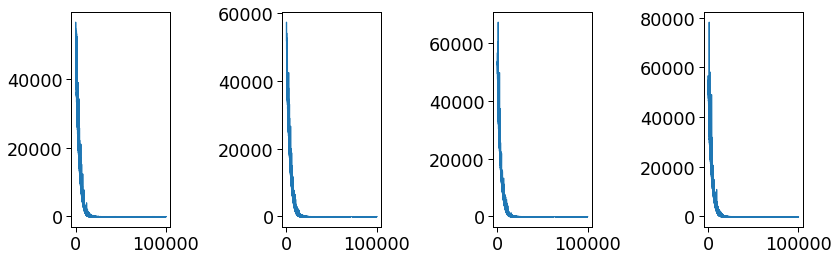

In [46]:
fig, ax = plt.subplots(ncols=n_chains, figsize=(12, 4)) 
for i in range(n_chains) :
    ax[i].plot(loss_mf[i])
fig.tight_layout()

In [44]:
posterior_mf = dict_from_list_of_dicts(posterior_mf_list)

az.summary(az.from_dict(posterior_mf), var_names=my_var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
g_1,0.516,0.090,0.344,0.664,0.003,0.002,798.0,733.0,1.01
g_2,0.652,0.002,0.649,0.655,0.000,0.000,16.0,201.0,1.19
g_3,0.149,0.000,0.148,0.150,0.000,0.000,128.0,718.0,1.04
g_4,0.217,0.000,0.216,0.218,0.000,0.000,778.0,813.0,1.01
delta,12.331,0.019,12.296,12.370,0.002,0.001,100.0,648.0,1.04
tau_i,7.720,0.018,7.689,7.754,0.001,0.001,147.0,547.0,1.04
h_i,17.815,0.038,17.747,17.885,0.001,0.001,836.0,687.0,1.01
tau_e,5.703,0.007,5.690,5.718,0.000,0.000,763.0,783.0,1.01
h_e,1.903,0.004,1.894,1.910,0.001,0.001,12.0,48.0,1.27
u,3.356,0.409,2.533,4.069,0.016,0.011,686.0,798.0,1.00


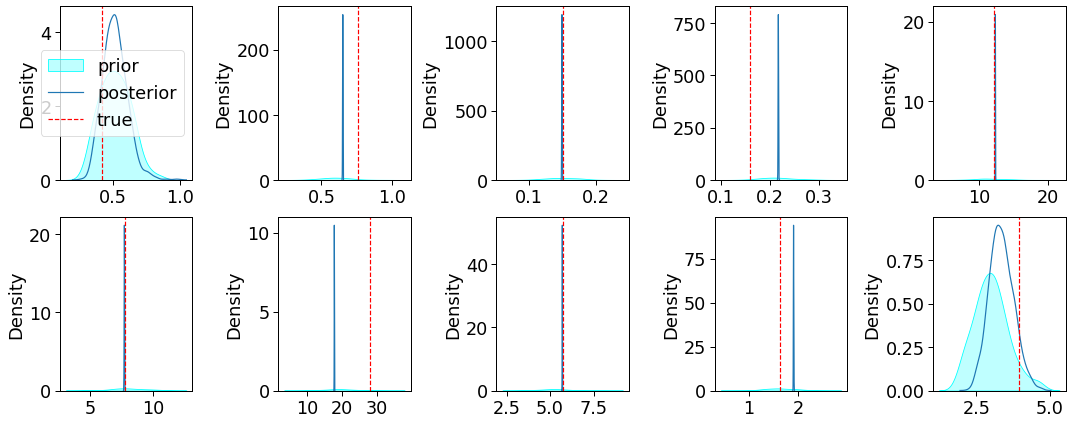

In [45]:
fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(15, 6))
for i in range(10) :
    sns.kdeplot(prior_predictions[my_var_names[i]], ax=ax[i//5, i%5], color='cyan', zorder=0, fill=True,
               label='prior')
    sns.kdeplot(np.array(posterior_mf[my_var_names[i]]).flatten(), 
                ax=ax[i//5, i%5], label='posterior')
    ax[i//5, i%5].axvline(theta_true[i], color='red', linestyle='--', label='true')
ax[0, 0].legend() 
fig.tight_layout() 
plt.show()

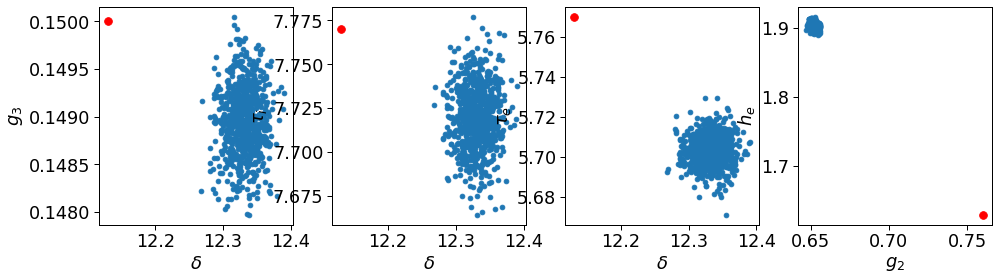

In [46]:
prms_sel = [('delta', 'g_3'), ('delta', 'tau_i'), ('delta', 'tau_e'), ('g_2', 'h_e')]
var_labels_sel = [(r'$\delta$', r'$g_3$'), (r'$\delta$', r'$\tau_i$'), (r'$\delta$', r'$\tau_e$'), (r'$g_2$', r'$h_e$')]
len_sel = len(prms_sel)

fig, ax = plt.subplots(ncols=len(prms_sel), figsize=(4*len_sel, len_sel))

for i in range(len_sel) :
    seli, selj = prms_sel[i]
    ax[i].scatter(posterior_mf[seli], posterior_mf[selj])
    ax[i].scatter(params_true[seli], params_true[selj], s=60, c='red')
    ax[i].set(xlabel=var_labels_sel[i][0], ylabel=var_labels_sel[i][1])

In [47]:
marks_mf = compute_marks(az.from_dict(posterior_mf))
bench_df = append_marks(bench_df, 'Mean field', sum(time_mf), marks_mf)

## VI Laplace approximation

In [51]:
optimizer = Adam(lr)
guide_lp = AutoLaplaceApproximation(model)
svi_lp = SVI(model, guide_lp, optimizer, loss=Trace_ELBO())

In [52]:
loss_lp = []
params_lp = []
posterior_lp_list = []
time_lp = []

rng_key = jax.random.PRNGKey(0)

for _ in range(n_chains) :
    
    start = time.time()
    rng_key, rng_subkey = random.split(key=rng_key)
    
    init_state = svi_lp.init(rng_key, data, prior_specs)
    svi_lp_result = svi_lp.run(rng_key, n_iters, data, prior_specs, init_state=init_state)
    
    time_lp.append(time.time() - start)
    loss_lp.append(svi_lp_result.losses)
    params_svi = svi_lp_result.params
    params_lp.append(params_svi)
    posterior_lp_list.append(guide_lp.sample_posterior(rng_key, params_svi, sample_shape=(200,)))
    
    print('SVI Auto Laplace Approx took ', time_lp[-1], ' seconds')

100%|█| 100000/100000 [00:37<00:00, 2652.26it/s, init loss: 56340.2852, avg. los


SVI Auto Laplace Approx took  46.87530970573425  seconds


100%|█| 100000/100000 [00:37<00:00, 2649.45it/s, init loss: 56340.2852, avg. los


SVI Auto Laplace Approx took  46.966963052749634  seconds


100%|█| 100000/100000 [00:38<00:00, 2589.11it/s, init loss: 56340.2852, avg. los


SVI Auto Laplace Approx took  47.143255949020386  seconds


100%|█| 100000/100000 [00:38<00:00, 2606.37it/s, init loss: 56340.2852, avg. los


SVI Auto Laplace Approx took  46.77226543426514  seconds


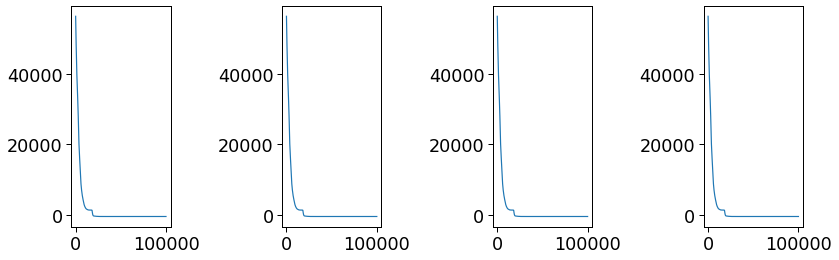

In [53]:
fig, ax = plt.subplots(ncols=n_chains, figsize=(12, 4)) 
for i in range(n_chains) :
    ax[i].plot(loss_lp[i])
fig.tight_layout()

In [53]:
posterior_lp = dict_from_list_of_dicts(posterior_lp_list)

az.summary(az.from_dict(posterior_lp), var_names=my_var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
g_1,0.546,0.128,0.335,0.789,0.004,0.003,894.0,758.0,1.01
g_2,0.655,0.078,0.506,0.795,0.003,0.002,858.0,714.0,1.00
g_3,0.146,0.024,0.106,0.196,0.001,0.001,836.0,863.0,1.00
g_4,0.212,0.034,0.150,0.280,0.001,0.001,910.0,607.0,1.00
delta,12.376,0.392,11.715,13.109,0.014,0.010,808.0,767.0,1.00
tau_i,7.711,0.087,7.528,7.860,0.003,0.002,711.0,700.0,1.00
h_i,19.295,3.467,13.066,25.710,0.124,0.088,772.0,681.0,1.00
tau_e,5.695,0.165,5.411,5.992,0.006,0.004,845.0,753.0,1.00
h_e,1.923,0.228,1.495,2.332,0.008,0.006,849.0,751.0,1.00
u,3.269,0.566,2.402,4.396,0.020,0.014,752.0,667.0,1.00


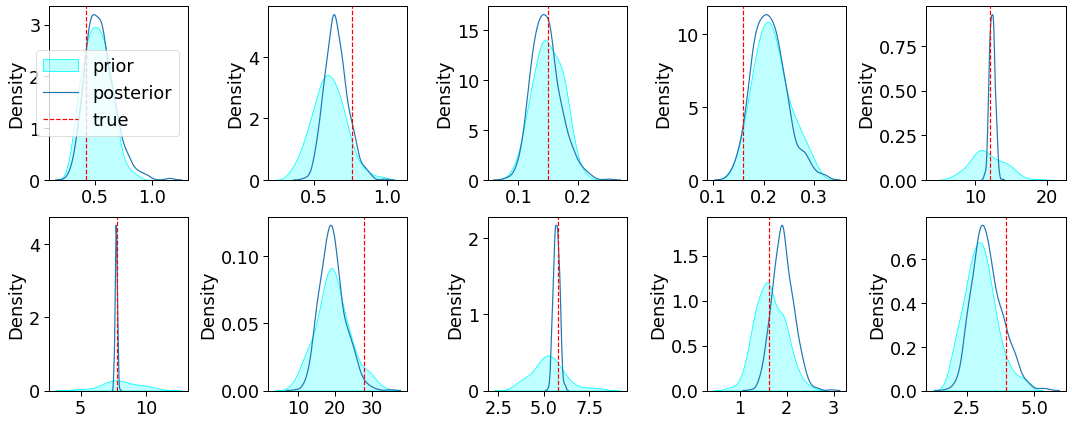

In [54]:
fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(15, 6))
for i in range(10) :
    sns.kdeplot(prior_predictions[my_var_names[i]], ax=ax[i//5, i%5], color='cyan', zorder=0, fill=True,
               label='prior')
    sns.kdeplot(np.array(posterior_lp[my_var_names[i]]).flatten(), 
                ax=ax[i//5, i%5], label='posterior')
    ax[i//5, i%5].axvline(theta_true[i], color='red', linestyle='--', label='true')
ax[0, 0].legend() 
fig.tight_layout() 
plt.show()

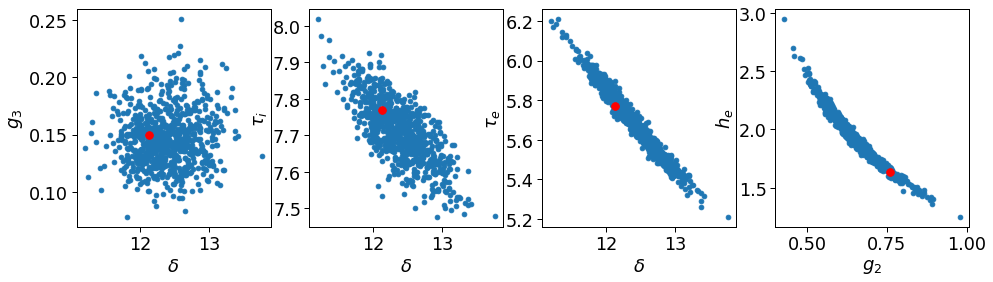

In [55]:
prms_sel = [('delta', 'g_3'), ('delta', 'tau_i'), ('delta', 'tau_e'), ('g_2', 'h_e')]
var_labels_sel = [(r'$\delta$', r'$g_3$'), (r'$\delta$', r'$\tau_i$'), (r'$\delta$', r'$\tau_e$'), (r'$g_2$', r'$h_e$')]
len_sel = len(prms_sel)

fig, ax = plt.subplots(ncols=len(prms_sel), figsize=(4*len_sel, len_sel))

for i in range(len_sel) :
    seli, selj = prms_sel[i]
    ax[i].scatter(posterior_lp[seli], posterior_lp[selj])
    ax[i].scatter(params_true[seli], params_true[selj], s=60, c='red')
    ax[i].set(xlabel=var_labels_sel[i][0], ylabel=var_labels_sel[i][1])

In [56]:
marks_lp = compute_marks(az.from_dict(posterior_lp))
bench_df = append_marks(bench_df, 'Laplace', sum(time_lp), marks_lp)

## HMC NUTS

In [78]:
# NUTS set up
kernel = NUTS(model, max_tree_depth=10,  dense_mass=False, adapt_step_size=True, init_strategy=init_fn)
mcmc= MCMC(kernel, num_warmup=200, num_samples=200, num_chains=n_chains)

In [79]:
#RUN NUTS
rng_key = jax.random.PRNGKey(0)
start_time = time.time()
mcmc.run(rng_key, data, prior_specs, extra_fields=('potential_energy', 'num_steps', 'diverging'))
time_nuts = time.time() - start_time
print(n_chains, " chains NUTS took (sec):" , time_nuts)

sample: 100%|█| 400/400 [00:58<00:00,  6.79it/s, 511 steps of size 7.16e-03. acc
sample: 100%|█| 400/400 [00:58<00:00,  6.80it/s, 511 steps of size 8.52e-03. acc
sample: 100%|█| 400/400 [00:56<00:00,  7.03it/s, 511 steps of size 9.75e-03. acc
sample: 100%|█| 400/400 [01:08<00:00,  5.85it/s, 1023 steps of size 6.55e-03. ac


4  chains NUTS took (sec): 245.19501328468323


In [80]:
posterior_nuts = mcmc.get_samples()

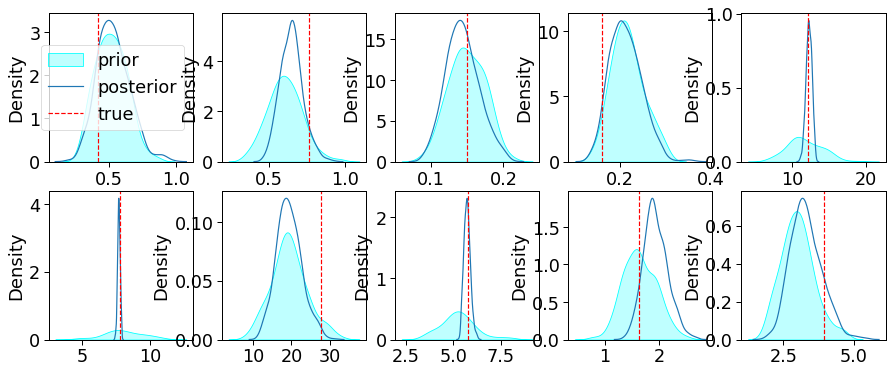

In [81]:
fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(15, 6))
for i in range(10) :
    sns.kdeplot(prior_predictions[my_var_names[i]], ax=ax[i//5, i%5], color='cyan', zorder=0, fill=True,
               label='prior')
    sns.kdeplot(np.array(posterior_nuts[my_var_names[i]]).flatten(), 
                ax=ax[i//5, i%5], label='posterior')
    ax[i//5, i%5].axvline(theta_true[i], color='red', linestyle='--', label='true')
ax[0, 0].legend() ;

In [82]:
params_true = dict(zip(my_var_names, theta_true))

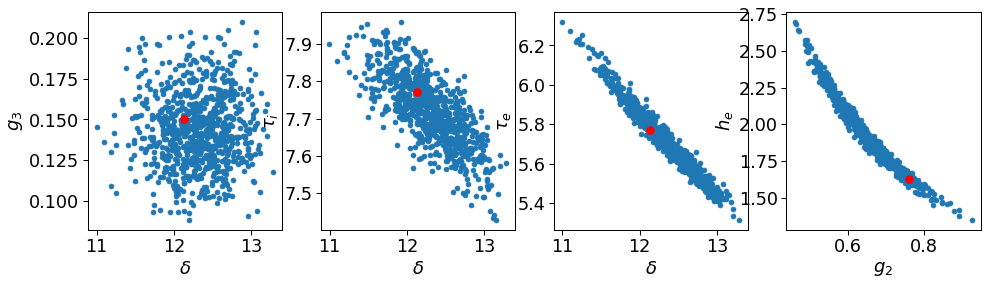

In [83]:
prms_sel = [('delta', 'g_3'), ('delta', 'tau_i'), ('delta', 'tau_e'), ('g_2', 'h_e')]
var_labels_sel = [(r'$\delta$', r'$g_3$'), (r'$\delta$', r'$\tau_i$'), (r'$\delta$', r'$\tau_e$'), (r'$g_2$', r'$h_e$')]
len_sel = len(prms_sel)

fig, ax = plt.subplots(ncols=len(prms_sel), figsize=(4*len_sel, len_sel))

for i in range(len_sel) :
    seli, selj = prms_sel[i]
    ax[i].scatter(posterior_nuts[seli], posterior_nuts[selj])
    ax[i].scatter(params_true[seli], params_true[selj], s=60, c='red')
    ax[i].set(xlabel=var_labels_sel[i][0], ylabel=var_labels_sel[i][1])

In [86]:
marks_nuts = compute_marks(az.from_dict(posterior_nuts))
bench_df = append_marks(bench_df, 'NUTS', time_nuts, marks_nuts)

## Summary

In [87]:
from matplotlib.ticker import MaxNLocator

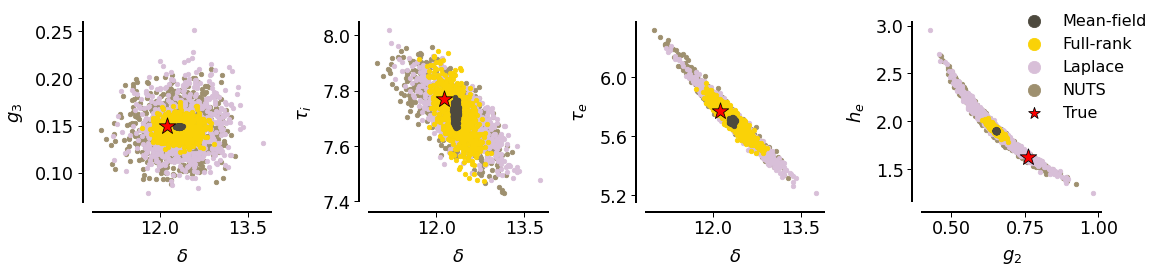

In [88]:
methods_posteriors = [posterior_mf, posterior_fr, posterior_lp, posterior_nuts]
methods = ['mf', 'fr', 'lp', 'nuts']
zorders=[10, 5, 2, 1, 100]
colors=['#4d493e', '#fad207', 'thistle', '#9e906f']
color_true = 'red'
s=[20, 20, 20, 20]

params_true = dict(zip(my_var_names, theta_true))
sns.set_context("paper", font_scale=2, rc={"axes.labelsize":18})
prms_sel = [('delta', 'g_3'), ('delta', 'tau_i'), ('delta', 'tau_e'), ('g_2', 'h_e')]
var_labels_sel = [(r'$\delta$', r'$g_3$'), (r'$\delta$', r'$\tau_i$'), (r'$\delta$', r'$\tau_e$'), (r'$g_2$', r'$h_e$')]
len_sel = len(prms_sel)


fig, ax = plt.subplots(ncols=len(prms_sel), figsize=(4*len_sel, len_sel))

for i in range(len_sel) :
    
    seli, selj = prms_sel[i]
    
    for ipost, post in enumerate(methods_posteriors) :
        ax[i].scatter(post[seli], post[selj], color=colors[ipost], s=s[ipost], label=methods[ipost], zorder=zorders[ipost])
    
        if methods == 'nuts' :
            x = np.array(post[seli])
            y = np.array( post[selj])
            qx_low, qx_high = np.quantile(x, 0.005), np.quantile(x, 0.995)
            qy_low, qy_high = np.quantile(y, 0.005), np.quantile(y, 0.995)
            x_low, x_high = ax[i].get_xlim()
            y_low, y_high = ax[i].get_ylim()
            ax[i].set_xlim(max(qx_low, x_low), min(qx_high, x_high))
            ax[i].set_ylim(max(qy_low, y_low), min(qy_high, y_high))
            
    ax[i].scatter(params_true[seli], params_true[selj], s=300, c=color_true, zorder=zorders[-1], 
                  marker='*', edgecolors='k', label='true')
    ax[i].set_xlabel(var_labels_sel[i][0], labelpad=10)
    ax[i].set_ylabel(var_labels_sel[i][1], labelpad=10)
    ax[i].xaxis.set_major_locator(MaxNLocator(nbins = 3))
    ax[i].yaxis.set_major_locator(MaxNLocator(nbins = 4))
    
    for a in ['top','bottom','left','right']:
        ax[i].spines[a].set_linewidth(2)
sns.despine(offset=10)
fig.tight_layout()

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
labels = ['Mean-field', 'Full-rank', 'Laplace', 'NUTS', 'True']
unique = [(h, l) for i, (h, l) in enumerate(zip(lines, labels)) if l not in labels[:i]]
legend = fig.legend(*zip(*unique), bbox_to_anchor=(1.02, 1), frameon=False, fontsize=16,
                    handler_map={PathCollection: HandlerPathCollection(update_func=update_prop)})

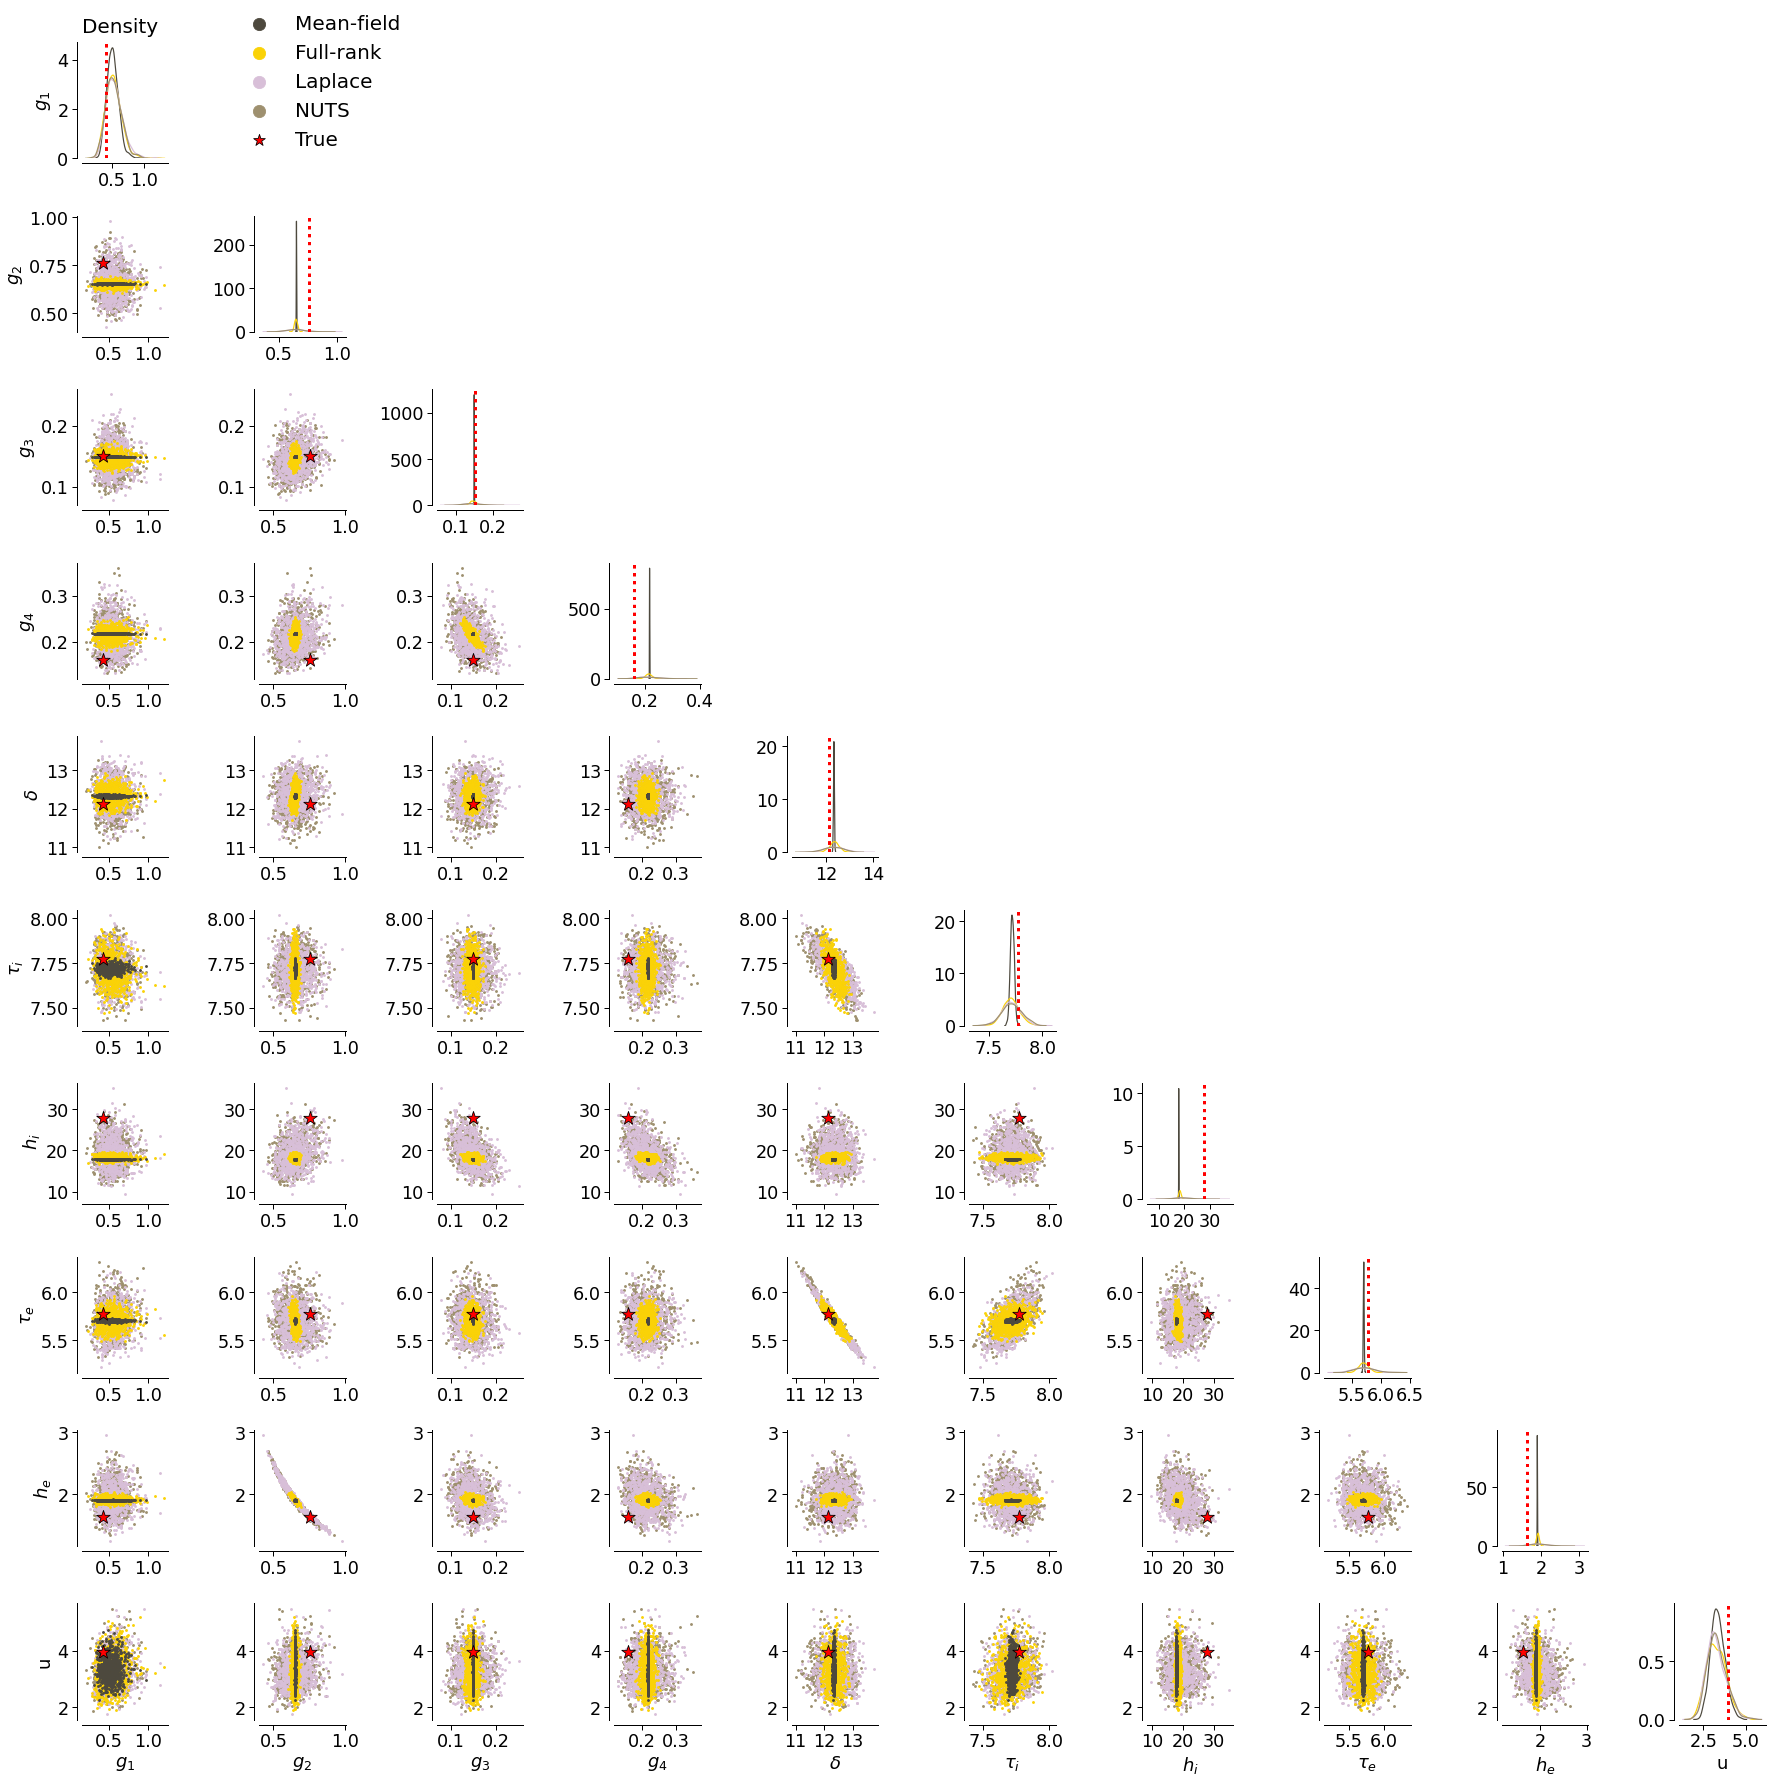

In [89]:
sns.set_context("paper", font_scale=2, rc={"axes.labelsize":18})
traces_dict = dict(zip(['mean field', 'full rank', 'lp', 'nuts'], 
                       [posterior_mf, posterior_fr, posterior_lp, posterior_nuts]))
my_var_names = ['g_1', 'g_2', 'g_3', 'g_4', 'delta', 'tau_i', 'h_i', 'tau_e', 'h_e', 'u']
var_labels = [r'$g_1$', r'$g_2$', r'$g_3$', r'$g_4$', r'$\delta$', r'$\tau_i$', r'$h_i$', r'$\tau_e$', r'$h_e$', 'u']
theta_true = np.array([0.42, 0.76, 0.15, 0.16, 12.13, 7.77, 27.87, 5.77, 1.63, 3.94])
params_true_dict = dict(zip(my_var_names, theta_true))

fig, ax = plot_pairs_surperimposed(traces_dict,
                                   my_var_names,
                                   main_palette=['#4d493e', '#fad207', 'thistle', '#9e906f'],
                                   true_values_dict=params_true_dict,
                                   z_orders=[10, 5, 2, 1, 100])

for ia, a in enumerate(ax[:, 0]) :
    a.set_ylabel(var_labels[ia])
for ia, a in enumerate(ax[-1, :]) :
    a.set_xlabel(var_labels[ia])
    
h = fig.legends[0].legendHandles
fig.legends[0].set_visible(0)
fig.legend(handles=h, labels=['Mean-field', 'Full-rank', 'Laplace', 'NUTS', 'True'], 
           bbox_to_anchor=(0.24, 1), fontsize=20, frameon=False,)    
fig.tight_layout()
#for fmt in fmts :
#    fig.savefig('figs/numpyro_pairplot' + fmt, dpi=200, bbox_inches='tight')

In [93]:
bench_df[['setup', 'time', 'mean r hat', 'MSE fit', 'min corr', 'max corr', 'mean corr', 
          'min zscore', 'max zscore']]

,setup,time,mean r hat,MSE fit,min corr,max corr,mean corr,min zscore,max zscore
0,Full rank,779.127115,1.003257,0.011713763,0.001577,0.922085,0.152737,0.421747,19.578947
1,Mean field,193.582863,1.062247,0.011791587,0.003790,0.233890,0.044933,1.067554,266.635381
2,Laplace,187.757794,1.002042,0.011831261,0.004037,0.982295,0.172730,0.150379,2.475103
3,NUTS,245.195013,1.008955,2.6193898,0.002274,0.981779,0.176007,0.243371,2.560342


In [94]:
pd.to_pickle(bench_df, 'bench_advi_numpyro.pkl')
bench_df.to_csv('bench_advi_numpyro.csv')

# Setup info

In [95]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Mon Jul 08 2024

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

numpyro   : 0.12.1
numpy     : 1.26.4
arviz     : 0.17.0
pandas    : 1.4.3
matplotlib: 3.5.2
jax       : 0.4.13
torch     : 2.0.0
sys       : 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
seaborn   : 0.13.2

Watermark: 2.4.3



In [96]:
!  lscpu | head -n 16

Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Address sizes:                   39 bits physical, 48 bits virtual
Byte Order:                      Little Endian
CPU(s):                          8
On-line CPU(s) list:             0-7
Vendor ID:                       GenuineIntel
Model name:                      Intel(R) Core(TM) i7-7700 CPU @ 3.60GHz
CPU family:                      6
Model:                           158
Thread(s) per core:              2
Core(s) per socket:              4
Socket(s):                       1
Stepping:                        9
CPU max MHz:                     4200.0000
CPU min MHz:                     800.0000
